Import modules

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

base_path = "Dataset/cifake"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")


Loading datasets using ImageFolder and DataLoaders

In [2]:
# convert to tensors and normalise pixel values to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

image, label = train_dataset[0] 
print(f"Dataset Shape: {train_dataset.__len__()}")
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")  # (batch, channel, height, width)
print(f"Batch label shape: {labels.shape}")  # (batch,)
print(f"Labels: {labels}")

print(f"Class-to-Label Mapping: {train_dataset.class_to_idx}")

Dataset Shape: 100000
Image shape: torch.Size([3, 32, 32])
Label: 0
Batch image shape: torch.Size([64, 3, 32, 32])
Batch label shape: torch.Size([64])
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1])
Class-to-Label Mapping: {'FAKE': 0, 'REAL': 1}


showing image samples

In [3]:
import matplotlib.pyplot as plt
import torch


def show_real_vs_fake_images(data_loader, class_names):
    """
    Displays 2 real CIFAR-10 images (label 1) and 2 AI-generated images (label 0) side by side.

    Args:
        data_loader: DataLoader object containing the images and labels.
        class_names: List of class names corresponding to the dataset.
    """
    real_images = []
    fake_images = []

    for features, labels in data_loader:
        for i in range(len(labels)):
            if len(real_images) < 2 and labels[i].item() == 1:  # real images
                real_images.append(features[i])
            elif len(fake_images) < 2 and labels[i].item() == 0:  # fake images
                fake_images.append(features[i])
            if len(real_images) == 2 and len(fake_images) == 2:
                break
        if len(real_images) == 4 and len(fake_images) == 4:
            break

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle("Top Row: Real CIFAR-10 | Bottom Row: AI-Generated", fontsize=14)

    for i, img in enumerate(real_images):
        img = img.permute(1, 2, 0)  # convert (C, H, W) to (H, W, C)
        img = img / 2 + 0.5  # pixel values from [-1, 1] to [0, 1]
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Label: {class_names[1]}")
        axes[0, i].axis("off")

    for i, img in enumerate(fake_images):
        img = img.permute(1, 2, 0)
        img = img / 2 + 0.5  
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Label: {class_names[0]}")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

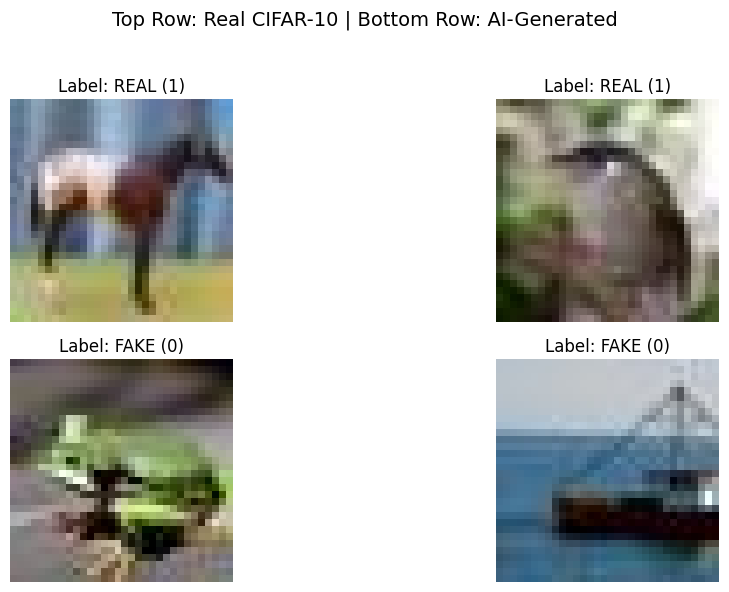

In [4]:
class_names = ["FAKE (0)", "REAL (1)"]
show_real_vs_fake_images(train_loader, class_names)

Creating model

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1,
                               padding=1)  # Input: (3, 32, 32) Output: (32, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,
                               padding=1)  # Input: (32, 32, 32) Output: (64, 32, 32)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,
                               padding=1)  # Input: (64, 32, 32) Output: (128, 32, 32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # dimension / 2

        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=512)  # flatten output from pool
        self.fc2 = nn.Linear(in_features=512, out_features=1)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Output: (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (64, 16, 16)
        x = self.pool(F.relu(self.conv3(x)))  # Output: (128, 8, 8)

        x = x.view(-1, 128 * 8 * 8)  # flatten to (batch_size, 128 * 8 * 8)

        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)  # no need for activation, BCELossWithLogits combines sigmoid

        return x

In [6]:
model = CNNModel()

print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [7]:
def train_model(model, device, train_loader, optimizer, loss_fn, epochs, lambda_L1=0.0):
    loss_hist = []
    
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            labels = labels.unsqueeze(1).float()

            # compute loss
            loss = loss_fn(outputs, labels)

            # L1 penalty
            if lambda_L1 > 0.0:
                L1_loss = sum(p.abs().sum() for p in model.parameters())
                loss = loss + lambda_L1 * L1_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * inputs.size(0)

        avg_epoch_loss = epoch_loss / len(train_loader.dataset)
        loss_hist.append(avg_epoch_loss)

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    return loss_hist

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
lambda_L1 = 1e-4
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
loss_history = train_model(model, device, train_loader, optimizer, loss_fn, epochs, lambda_L1)

Epoch 0/50, Loss: 0.5101


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x176de2340>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

Plotting loss

In [ ]:
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Saving model

In [66]:
# PATH = './cifar_net.pth'
# torch.save(model.state_dict(), PATH)

Evaluating the model